In [416]:
import os
import pandas as pd
import re
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the CSV data into a DataFrame
csv_file = "combined_data.csv"
df = pd.read_csv(csv_file)

df.dropna(subset=['body'], inplace=True)
df.drop_duplicates(subset='body', inplace=True)
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
filtered_df = df[df['word_count'] < 15]
filtered_df = filtered_df.drop(columns=['word_count'])
df = filtered_df

flagged_df = df.iloc[:len(df) // 2]
non_flagged_df = df.iloc[len(df) // 2:]

num_samples_per_class = 30000
# Randomly sample from each class to create a balanced dataset
flagged_sampled = flagged_df.sample(n=num_samples_per_class, random_state=50)
non_flagged_sampled = non_flagged_df.sample(n=num_samples_per_class, random_state=50)

# # Concatenate the sampled DataFrames to create the balanced dataset
df = pd.concat([flagged_sampled, non_flagged_sampled], ignore_index=True)

'''
Added 2 more pre processing steps.
'''

import pandas as pd
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
import contractions
def preprocess_text(text):
    if pd.isna(text) or not text.strip():
        return ''  # Replace empty strings or NaN with an empty string
    
    text = text.lower()
    text = re.sub(r'[^\w\s,]', '', text)
    text = re.sub(r'[0-9]', '', text)
    text = ''.join(char for char in text if ord(char) < 128)
    
    # Normalize contractions
    text = contractions.fix(text)
    
    # Tokenize the text using NLTK's word_tokenize
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))  # Change 'english' to your language if needed
    words = [word for word in words if word not in stop_words]
    
    # Perform stemming and lemmatization
    '''
    Stemmer and lemmatizer are going to convert a word to it's root form.
    '''
    # stemmer = PorterStemmer()
    # lemmatizer = WordNetLemmatizer()
    # words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words]
    
    return ' '.join(words)

df['body'] = df['body'].apply(preprocess_text)
# Check the number of rows in the DataFrame after preprocessing
num_rows = df.shape[0]
print(f'Number of rows after preprocessing: {num_rows}')

# Label Encoding
df['label'] = df['label'].map({'deleted': 1, 'hidden': 1, 'nonflagged': 0})

Number of rows after preprocessing: 60000


In [417]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token = '<nothing>')
tokenizer.fit_on_texts(df['body'])

sequences = tokenizer.texts_to_sequences(df['body'])
from keras.utils import pad_sequences
sequences = pad_sequences(sequences, padding = 'post')
sequences

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [ 909,  309, 3046, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [ 157,   80,  102, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [461]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label Encoding for the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, df['label'], test_size=0.8, random_state=42)

In [462]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, Dropout
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming 'max_sequence_length' is the maximum length of your sequences
max_sequence_length = max(len(seq) for seq in sequences)

model = Sequential()

# Add an Embedding layer with a slightly larger dimension
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=32,  # Increased embedding dimension
                    input_length=max_sequence_length))

# Add the first SimpleRNN layer with L2 regularization
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.1))  # Adding dropout for regularization

# Add a second SimpleRNN layer with L2 regularization
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.1))  # Adding dropout for regularization

model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.1))  # Adding dropout for regularization

# Add a Dense layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile and fit the model as before
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(sequences, df['label'], epochs=7, validation_split=0.2)

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_104 (Embedding)   (None, 16, 32)            641184    
                                                                 
 simple_rnn_238 (SimpleRNN)  (None, 16, 64)            6208      
                                                                 
 dropout_145 (Dropout)       (None, 16, 64)            0         
                                                                 
 simple_rnn_239 (SimpleRNN)  (None, 16, 64)            8256      
                                                                 
 dropout_146 (Dropout)       (None, 16, 64)            0         
                                                                 
 simple_rnn_240 (SimpleRNN)  (None, 16, 64)            8256      
                                                                 
 dropout_147 (Dropout)       (None, 16, 64)         

In [463]:
print(f'Training Accuracy (last epoch): {history.history["accuracy"][-1] * 100:.2f}%')
print(f'Validation Accuracy (last epoch): {history.history["val_accuracy"][-1] * 100:.2f}%')

Training Accuracy (last epoch): 70.39%
Validation Accuracy (last epoch): 85.36%


In [466]:
print(f'Final Training Loss: {history.history["loss"][-1]}')
print(f'Final Validation Loss: {history.history["val_loss"][-1]}')

Final Training Loss: 0.498085618019104
Final Validation Loss: 0.8031561970710754


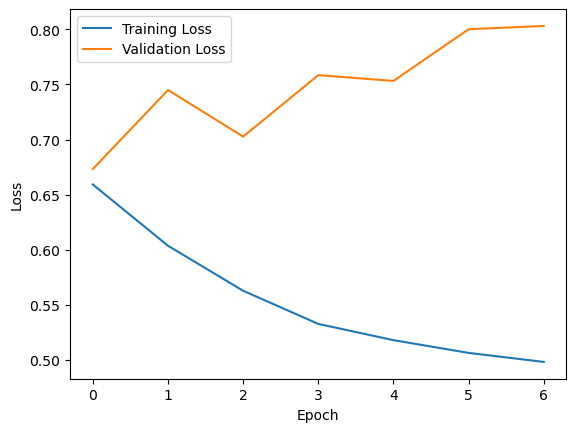

In [467]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

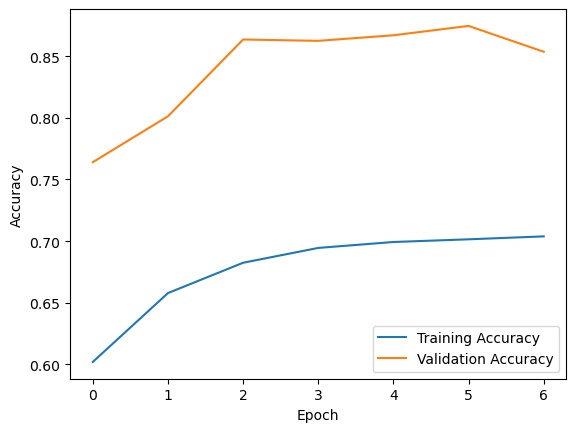

In [468]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Manually entering accuracy and val_accuracy values
test_values = [0.5541, 0.6013, 0.6135, 0.6124, 0.6170, 0.668, 0.6745]
train_values = [0.5521, 0.6079, 0.6325, 0.6445, 0.6493, 0.7600, 0.7515]

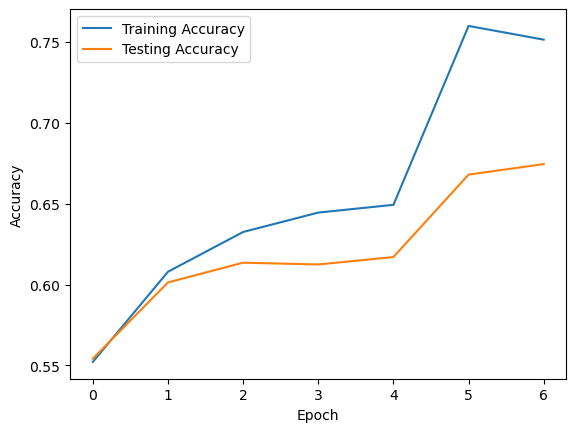

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_values, label='Training Accuracy')
plt.plot(test_values, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()